## Пункт 11

«Творческое задание» на поиск аномалий. Загрузите файл `mnist_small.csv`. Данный набор данных содержит подмножество эталонного набора данных рукописных цифр MNIST. 5923 картинок 28x28 пикселей с изображением нуля и 76 картинок с изображением шестерки. Задача состоит в том, чтобы с использованием метода `SVM` построить одноклассовую модель на основе поиска аномалий, которая максимально хорошо отфильтрует шестерки (как аномалии) от нулей (как основной выборки). Признаки картинок описываются их координатами (в названии переменных, например «10x12») и значением яркости точки по этим координатам. Подбирая параметры метода и преобразуя признаки как посчитаете нужным, но не используя при этом информацию о label, постройте модель выявления аномалий с ERR меньше 0.2.

In [34]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

data = pd.read_csv("mnist_small.csv")
X = data.drop(columns=["label"])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test = train_test_split(X_scaled, test_size=0.8, random_state=42)

model = OneClassSVM(nu=0.1, kernel="rbf", gamma="auto")
model.fit(X_train)
scores = model.decision_function(X_scaled)

threshold = np.percentile(scores, 10)
predictions = scores < threshold  # True — аномалия



y = data["label"]
fpr, tpr, thresholds = roc_curve(y, -scores, pos_label=6)
eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
eer_threshold = thresholds[eer_index]
eer = fpr[eer_index]
print(f"EER: {eer:.3f}")


EER: 0.123


## Пункт 12

Постройте ROC кривую с ERR. Выведите 4 картинки с числами (28 на 28 пикселей):  

- самый типичный “0” – true negative с минимальной аномальностью 
- самая аномальная “6” – true positive с максимальной аномальностью 
- самый нетипичный “0” – false positive с максимальной аномальностью 
- самая неаномальная “6” – false negative с минимальной аномальностью

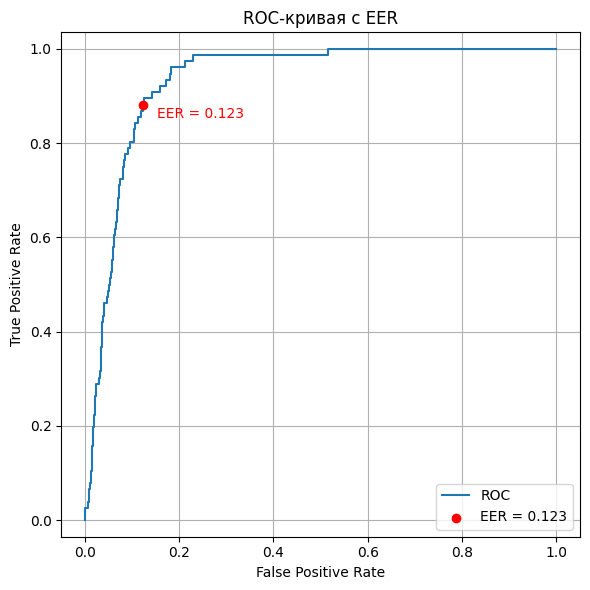

In [30]:
import matplotlib.pyplot as plt

# Построение ROC-кривой
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="ROC")

# Отметим точку EER на графике
eer_fpr = fpr[eer_index]
eer_tpr = tpr[eer_index]

plt.scatter([eer_fpr], [eer_tpr], color="red", zorder=5, label=f"EER = {eer:.3f}")
plt.annotate(f"EER = {eer:.3f}", (eer_fpr, eer_tpr), textcoords="offset points", xytext=(10, -10), ha="left", fontsize=10, color="red")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая с EER")
plt.legend(loc="lower right")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

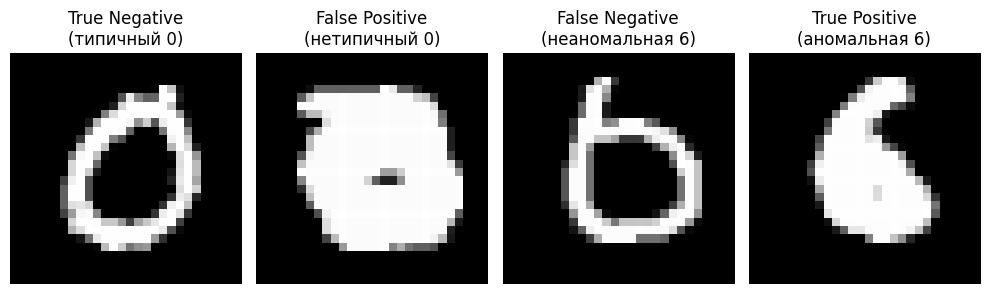

In [ ]:
predictions = -scores > eer_threshold  # отрицательные, потому что roc_curve был по -scores

labels = y.values
true_labels = labels == 6  
pred_labels = predictions  # True = аномалия

# Индексы нужных случаев
TP_idx = np.where((pred_labels == True) & (true_labels == True))[0]       # True Positive
TN_idx = np.where((pred_labels == False) & (true_labels == False))[0]     # True Negative
FP_idx = np.where((pred_labels == True) & (true_labels == False))[0]      # False Positive
FN_idx = np.where((pred_labels == False) & (true_labels == True))[0]      # False Negative

# Поиск нужных по "наиболее/наименее аномальному" (т.е. по score)
TP_most_anomalous = TP_idx[np.argmin(scores[TP_idx])]     # min score = max anomaly
TN_least_anomalous = TN_idx[np.argmax(scores[TN_idx])]    # max score = min anomaly
FP_most_anomalous = FP_idx[np.argmin(scores[FP_idx])]
FN_least_anomalous = FN_idx[np.argmax(scores[FN_idx])]

# Функция для отображения
def show_digit(index, title):
    image = X.iloc[index].values.reshape(28, 28)
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")

# Визуализация
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
show_digit(TN_least_anomalous, "True Negative\n(типичный 0)")

plt.subplot(1, 4, 2)
show_digit(FP_most_anomalous, "False Positive\n(нетипичный 0)")

plt.subplot(1, 4, 4)
show_digit(TP_most_anomalous, "True Positive\n(аномальная 6)")

plt.subplot(1, 4, 3)
show_digit(FN_least_anomalous, "False Negative\n(неаномальная 6)")

plt.tight_layout()
plt.show()